# Finding the best classifier for predicting a default of a loan

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
# !wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# # notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

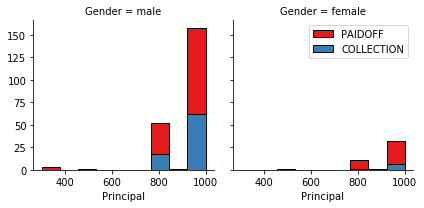

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

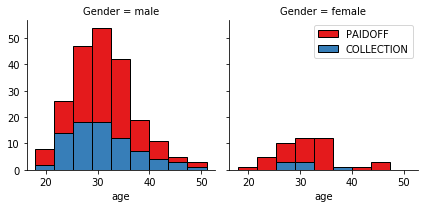

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

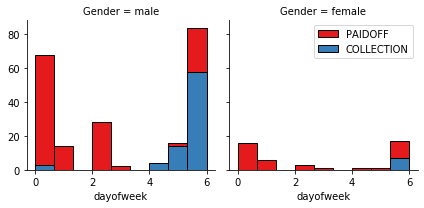

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [17]:
Feature.shape

(346, 8)

### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

## GLOBAL VARIABLES AND COMMENTS

(I left these here, under KNN so hat they are not missed the reviewer in data processing)

1. In order to maximize the amount of data I use for training, maximizing accuracy and reducing overfitting, I'll use cross-validation technique instead of train/test split in order to optimize parametrs, and then I'll use the whole X and y set to build the classifier. I will use StratifiedKFold() to split the data during cross-validation in order to make sure that the two target classes are split evently into each split.

2. Since we are predicting whether or not someone would go into COLLECTION, I'm going to assume that that's our positive label for statistical metrics, such as F1 Score. The bank is very interested in making sure that our model doesn't miss someone that would end up defaulting, so to optimize my parameters I will use F1 score for the positive label (i.e., 'COLLECTION'), instead of weighted average of the two classes as we did in class. For the final REPORT, I will present the weighted average F1 SCORE, but I will aslo show the F1 Score for the "COLLECTION" class for the test data.

In [21]:
from sklearn.model_selection import StratifiedKFold

I will create an f1_scorer (to specift the positive label and keep "PAIDOFF"/"COLLECTION' labels) and jaccard_scorer to use throughout:

In [22]:
from sklearn import metrics
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(metrics.f1_score, pos_label="COLLECTION")
jaccard_scorer = make_scorer(metrics.jaccard_similarity_score)

Import cross_val_score to use for cross-validation:

In [23]:
from sklearn.model_selection import cross_val_score

I will filter out warnings about jaccard_similary_score going to be deprecated, to have less messy outputs. I will keep using jaccard_similary_score instead of recommended jaccard_score, since that's what the class notes and the assignment suggests. 

In [24]:
import warnings

warnings.filterwarnings("ignore", "jaccard_similarity_score", DeprecationWarning)

I'm going to create a list where I'm going to save all the metrics for my best fits with each Classifier

In [25]:
clfs_list = []

## Ready to Start Fitting

In [26]:
from sklearn.neighbors import KNeighborsClassifier

I will iterate about different Number of Neighbours to find the best:

In [27]:
def test_param_KNN(xaxis):
    cv = StratifiedKFold(5, shuffle=True, random_state=21)
    mean_accuracy = []
    SE_accuracy = []
    mean_f1score = []
    SE_f1score = []
    mean_jaccard = []
    SE_jaccard = []
    params = []
    for n in range(1, 12):
        loan_clf = KNeighborsClassifier(n_neighbors = n)
        mean_accuracy.append(cross_val_score(loan_clf, X, y, cv=cv, scoring='accuracy').mean())
        SE_accuracy.append(cross_val_score(loan_clf, X, y, cv=cv, scoring='accuracy').std()/np.sqrt(5))
        mean_f1score.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=f1_scorer).mean())
        SE_f1score.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=f1_scorer).std()/np.sqrt(5))
        mean_jaccard.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=jaccard_scorer).mean())
        SE_jaccard.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=jaccard_scorer).std()/np.sqrt(5))
        params.append(n)
    mean_accuracy = np.asarray(mean_accuracy)
    mean_f1score = np.asarray(mean_f1score)
    mean_jaccard = np.asarray(mean_jaccard)
    print(mean_accuracy)
    print(mean_f1score)
    print(mean_jaccard)
    plt.figure()
    plt.plot(params, mean_accuracy)
    plt.fill_between(params, mean_accuracy - 1 * SE_accuracy, mean_accuracy + 1 * SE_accuracy, alpha=0.10)
    plt.legend(('Accuracy ', '+/- StandErr'))
    plt.ylabel('Accuracy')
    plt.xlabel(xaxis)
    plt.figure()
    plt.plot(params, mean_f1score)
    plt.fill_between(params, mean_f1score - 1 * SE_f1score, mean_f1score + 1 * SE_f1score, alpha=0.10)
    plt.legend(('F1 Score (Collection)', '+/- StandErr'))
    plt.ylabel('F1 Score (Collection)')
    plt.xlabel(xaxis)
    plt.figure()
    plt.plot(params, mean_jaccard)
    plt.fill_between(params, mean_jaccard - 1 * SE_jaccard, mean_jaccard + 1 * SE_jaccard, alpha=0.10)
    plt.legend(('Jaccard Similarity Score', '+/- StandErr'))
    plt.ylabel('Jaccard Similarity Score')
    plt.xlabel(xaxis)
    print("")
    print( "The best accuracy was", round(mean_accuracy.max(), 5), "with %s =" % xaxis,  params[mean_accuracy.argmax()]) 
    print( "The best F1 Score (Collection) was", round(mean_f1score.max(), 5), "with %s =" % xaxis,  params[mean_f1score.argmax()]) 
    print( "The best Jaccard Similarity score was", round(mean_jaccard.max(), 5), "with %s =" % xaxis,  params[mean_jaccard.argmax()])
    best_fit = {
        '1: Classifier': 'loanKNN, %s %d' % (xaxis, params[mean_f1score.argmax()]),
        '2: Accuracy': mean_accuracy.max(),
        '3: F1 Score "COLLECTION"': mean_f1score.max(),
        '4: Jaccard': mean_jaccard.max(),
    }
    clfs_list.append(best_fit)

[0.67345756 0.64753623 0.71109731 0.69962733 0.74293996 0.73995859
 0.76020704 0.74281573 0.74865424 0.72273292 0.73416149]
[0.27337754 0.42423756 0.3601918  0.44887905 0.36447484 0.48684919
 0.4114313  0.45255592 0.33495482 0.3780118  0.31245421]
[0.67345756 0.64753623 0.71109731 0.69962733 0.74293996 0.73995859
 0.76020704 0.74281573 0.74865424 0.72273292 0.73416149]

The best accuracy was 0.76021 with Number of Neighbors (K) = 7
The best F1 Score (Collection) was 0.48685 with Number of Neighbors (K) = 6
The best Jaccard Similarity score was 0.76021 with Number of Neighbors (K) = 7


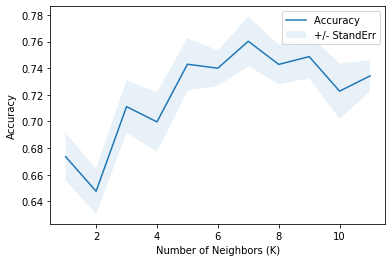

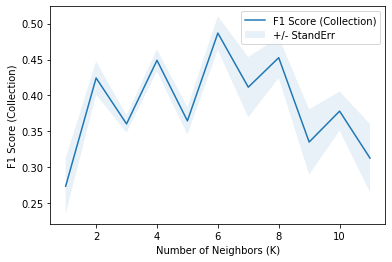

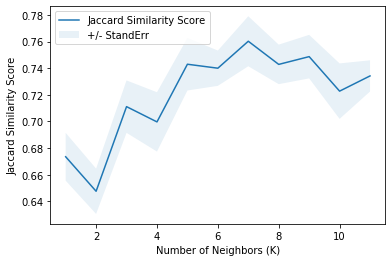

In [28]:
test_param_KNN('Number of Neighbors (K)')

In [29]:
pd.DataFrame(clfs_list)

,1: Classifier,2: Accuracy,"3: F1 Score ""COLLECTION""",4: Jaccard
0,"loanKNN, Number of Neighbors (K) 6",0.760207,0.486849,0.760207


Since it may be more important for the bank to predict who would go into collection, I'm going to go with F1-score for the positive label set to "COLLECTION", and build the classifier using K = 6. I'm using the entire feature set X and target y to train because I used cross-validation method to optimize parameters 

In [30]:
loanKNN = KNeighborsClassifier(n_neighbors = 6).fit(X, y)
loanKNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

# Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

I will iterate over different max_depth to see which one gives the best fit, ranging from 1 to 24, trying two criteria: "entropy" and "gini". Since the "COLLECTION" class is underrepresented in the target set, and that is the class we interested in predicting, I will use "balanced" class_weight, and compare it to class_weight=None

In [32]:
def test_param_DT(xaxis, criterion, class_weight):
    cv = StratifiedKFold(5, shuffle=True, random_state=21)
    mean_accuracy = []
    SE_accuracy = []
    mean_f1score = []
    SE_f1score = []
    mean_jaccard = []
    SE_jaccard = []
    params = []
    for n in range(1, 24):
        loan_clf = DecisionTreeClassifier(criterion=criterion, max_depth=n, class_weight=class_weight)
        mean_accuracy.append(cross_val_score(loan_clf, X, y, cv=cv, scoring='accuracy').mean())
        SE_accuracy.append(cross_val_score(loan_clf, X, y, cv=cv, scoring='accuracy').std()/np.sqrt(5))
        mean_f1score.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=f1_scorer).mean())
        SE_f1score.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=f1_scorer).std()/np.sqrt(5))
        mean_jaccard.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=jaccard_scorer).mean())
        SE_jaccard.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=jaccard_scorer).std()/np.sqrt(5))
        params.append(n)
    mean_accuracy = np.asarray(mean_accuracy)
    mean_f1score = np.asarray(mean_f1score)
    mean_jaccard = np.asarray(mean_jaccard)
    print(mean_accuracy)
    print(mean_f1score)
    print(mean_jaccard)
    plt.figure()
    plt.plot(params, mean_accuracy)
    plt.fill_between(params, mean_accuracy - 1 * SE_accuracy, mean_accuracy + 1 * SE_accuracy, alpha=0.10)
    plt.legend(('Accuracy ', '+/- StandErr'))
    plt.ylabel('Accuracy')
    plt.xlabel(xaxis)
    plt.figure()
    plt.plot(params, mean_f1score)
    plt.fill_between(params, mean_f1score - 1 * SE_f1score, mean_f1score + 1 * SE_f1score, alpha=0.10)
    plt.legend(('F1 Score "COLLECTION"', '+/- StandErr'))
    plt.ylabel('F1 Score "COLLECTION"')
    plt.xlabel(xaxis)
    plt.figure()
    plt.plot(params, mean_jaccard)
    plt.fill_between(params, mean_jaccard - 1 * SE_jaccard, mean_jaccard + 1 * SE_jaccard, alpha=0.10)
    plt.legend(('Jaccard Similarity Score', '+/- StandErr'))
    plt.ylabel('Jaccard Similarity Score')
    plt.xlabel(xaxis)
    print("")
    print( "The best accuracy was", round(mean_accuracy.max(), 5), "with %s =" % xaxis, params[mean_accuracy.argmax()]) 
    print( "The best F1 Score (Collection) was", round(mean_f1score.max(), 5), "with %s =" % xaxis, params[mean_f1score.argmax()]) 
    print( "The best Jaccard Similarity score was", round(mean_jaccard.max(), 5), "with %s =" % xaxis, params[mean_jaccard.argmax()])
    best_fit = {
        '1: Classifier': 'loanTree, %s %d, %s, %s' % (xaxis, params[mean_f1score.argmax()], criterion, class_weight),
        '2: Accuracy': mean_accuracy.max(),
        '3: F1 Score "COLLECTION"': mean_f1score.max(),
        '4: Jaccard': mean_jaccard.max(),
    }
    clfs_list.append(best_fit)

C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

[0.75146998 0.75146998 0.75146998 0.69668737 0.72277433 0.71407867
 0.68215321 0.67929607 0.67917184 0.70223602 0.67345756 0.69080745
 0.69656315 0.693706   0.68795031 0.68219462 0.67925466 0.6879089
 0.67929607 0.67349896 0.68219462 0.68501035 0.6821118 ]
[0.         0.         0.         0.13846154 0.11486486 0.21200291
 0.22278261 0.40462114 0.30928482 0.38846829 0.34149871 0.36351012
 0.37847953 0.38616893 0.40637501 0.3980294  0.38931913 0.38323408
 0.38865079 0.38297511 0.37486701 0.3952876  0.39701786]
[0.75146998 0.75146998 0.75146998 0.69668737 0.72277433 0.71407867
 0.68505176 0.67929607 0.67917184 0.70509317 0.67639752 0.69942029
 0.68786749 0.69089027 0.693706   0.67639752 0.67921325 0.68219462
 0.6879089  0.68219462 0.67921325 0.6879089  0.68501035]

The best accuracy was 0.75147 with Max Depth of Tree = 1
The best F1 Score (Collection) was 0.40638 with Max Depth of Tree = 15
The best Jaccard Similarity score was 0.75147 with Max Depth of Tree = 1


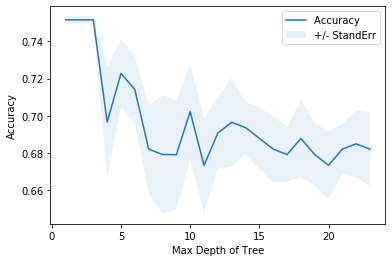

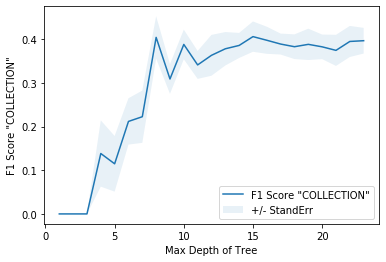

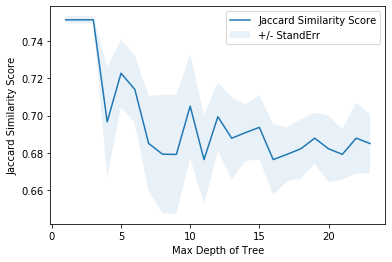

In [33]:
test_param_DT('Max Depth of Tree', 'entropy', None)

[0.63871636 0.6589648  0.64741201 0.65026915 0.6299793  0.64153209
 0.63283644 0.62140787 0.62716356 0.63291925 0.64459627 0.64741201
 0.65325052 0.66198758 0.66198758 0.65908903 0.67068323 0.67068323
 0.65908903 0.66488613 0.65908903 0.66778468 0.66488613]
[0.57040262 0.58477632 0.54839734 0.56767251 0.52522924 0.53232311
 0.52555834 0.51271416 0.49582407 0.49333505 0.48908749 0.4617649
 0.44926203 0.44145875 0.45688518 0.40491825 0.4169116  0.42653265
 0.40961326 0.41682502 0.41872777 0.42086681 0.41682502]
[0.63871636 0.6589648  0.64741201 0.6531677  0.6299793  0.64153209
 0.63863354 0.62140787 0.62426501 0.63581781 0.64169772 0.63875776
 0.65325052 0.66488613 0.66778468 0.65619048 0.66488613 0.66198758
 0.66488613 0.65908903 0.66198758 0.66488613 0.66198758]

The best accuracy was 0.67068 with Max Depth of Tree = 17
The best F1 Score (Collection) was 0.58478 with Max Depth of Tree = 2
The best Jaccard Similarity score was 0.66778 with Max Depth of Tree = 15


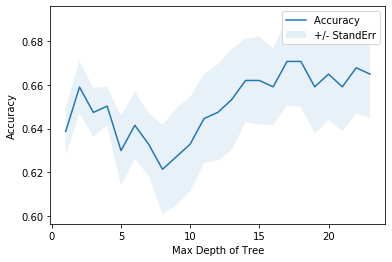

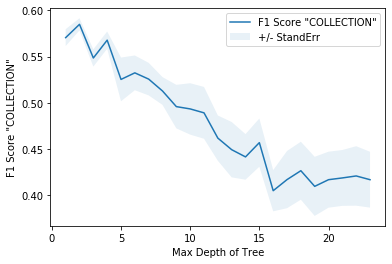

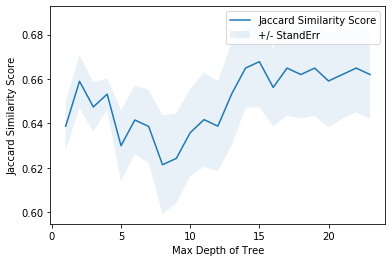

In [34]:
test_param_DT('Max Depth of Tree', 'entropy', "balanced")

C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

[0.75146998 0.75146998 0.73146998 0.69378882 0.72277433 0.71113872
 0.69664596 0.69080745 0.68492754 0.69929607 0.66190476 0.69072464
 0.67917184 0.67060041 0.6821118  0.66770186 0.67060041 0.66770186
 0.66766046 0.67341615 0.6763147  0.66480331 0.66770186]
[0.         0.         0.07179487 0.21253561 0.1029601  0.18769231
 0.35493797 0.31806689 0.30631366 0.39897661 0.35945166 0.37116728
 0.38607034 0.36732874 0.39336771 0.3822724  0.37014124 0.36834637
 0.37402205 0.36173977 0.37596245 0.37402205 0.37083425]
[0.75146998 0.75146998 0.73146998 0.69378882 0.72277433 0.71113872
 0.69664596 0.69080745 0.68492754 0.69929607 0.65900621 0.69362319
 0.67921325 0.67921325 0.67639752 0.66770186 0.67345756 0.66194617
 0.66766046 0.66480331 0.66194617 0.66770186 0.66480331]

The best accuracy was 0.75147 with Max Depth of Tree = 1
The best F1 Score (Collection) was 0.39898 with Max Depth of Tree = 10
The best Jaccard Similarity score was 0.75147 with Max Depth of Tree = 1


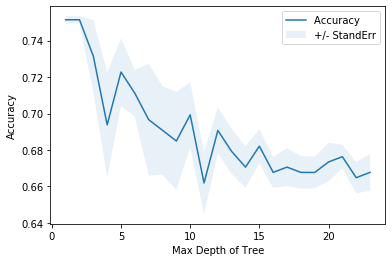

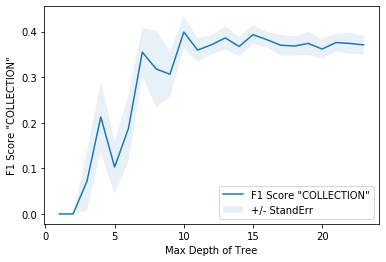

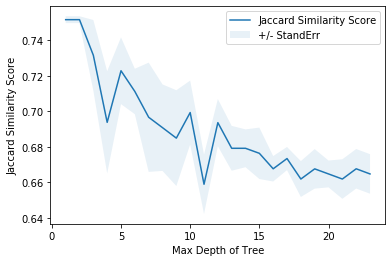

In [35]:
test_param_DT('Max Depth of Tree', 'gini', None)

[0.63871636 0.6589648  0.64741201 0.66186335 0.63585921 0.64741201
 0.63006211 0.63875776 0.63875776 0.6531677  0.64749482 0.65610766
 0.65035197 0.67064182 0.67643892 0.66774327 0.66774327 0.66484472
 0.66774327 0.66774327 0.66484472 0.66774327 0.66774327]
[0.57040262 0.58477632 0.54839734 0.57391033 0.52685281 0.53641097
 0.51607953 0.51317214 0.50855676 0.4854015  0.45787262 0.44535887
 0.4313774  0.44462803 0.46072326 0.44145849 0.4325696  0.4325696
 0.44145849 0.43405891 0.42946295 0.44373121 0.44373121]
[0.63871636 0.6589648  0.64741201 0.66186335 0.63585921 0.64741201
 0.63296066 0.64165631 0.64165631 0.6589648  0.65039337 0.65325052
 0.64745342 0.66774327 0.67354037 0.66484472 0.66774327 0.66774327
 0.66484472 0.67064182 0.67064182 0.66194617 0.66194617]

The best accuracy was 0.67644 with Max Depth of Tree = 15
The best F1 Score (Collection) was 0.58478 with Max Depth of Tree = 2
The best Jaccard Similarity score was 0.67354 with Max Depth of Tree = 15


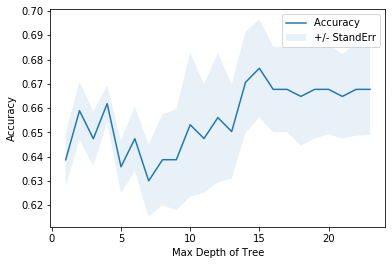

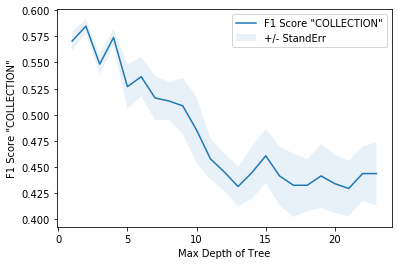

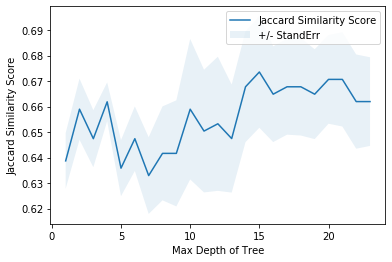

In [36]:
test_param_DT('Max Depth of Tree', 'gini', 'balanced')

In [37]:
pd.DataFrame(clfs_list)

,1: Classifier,2: Accuracy,"3: F1 Score ""COLLECTION""",4: Jaccard
0,"loanKNN, Number of Neighbors (K) 6",0.760207,0.486849,0.760207
1,"loanTree, Max Depth of Tree 15, entropy, None",0.751470,0.406375,0.751470
2,"loanTree, Max Depth of Tree 2, entropy, balanced",0.670683,0.584776,0.667785
3,"loanTree, Max Depth of Tree 10, gini, None",0.751470,0.398977,0.751470
4,"loanTree, Max Depth of Tree 2, gini, balanced",0.676439,0.584776,0.673540


Even though accuracy and jaccard scores are better when class_weight=None, those scores are determined by the fraction of "PAIDOFF" in the dataset. So I will use the F1 score, since it's a better indicator of how well we can predict "COLLECTION" class, to know if someone defaults on their loan. 

Therefore, I got the best scores using class_weight="balanced", criterion="gini", and max_depth=2, therefore I can build my Tree Classifier. 

NOTE: I'm using the entire feature set X and target y to train because I used cross-validation method to optimize parameters 

In [38]:
loanTree = DecisionTreeClassifier(max_depth = 2, criterion="gini", class_weight='balanced').fit(X, y)
loanTree 

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Let's plot the tree to see if it makes sense

Uncomment next cell and install pydotplus if don't have it installed

In [39]:
# !pip install pydotplus

In [40]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


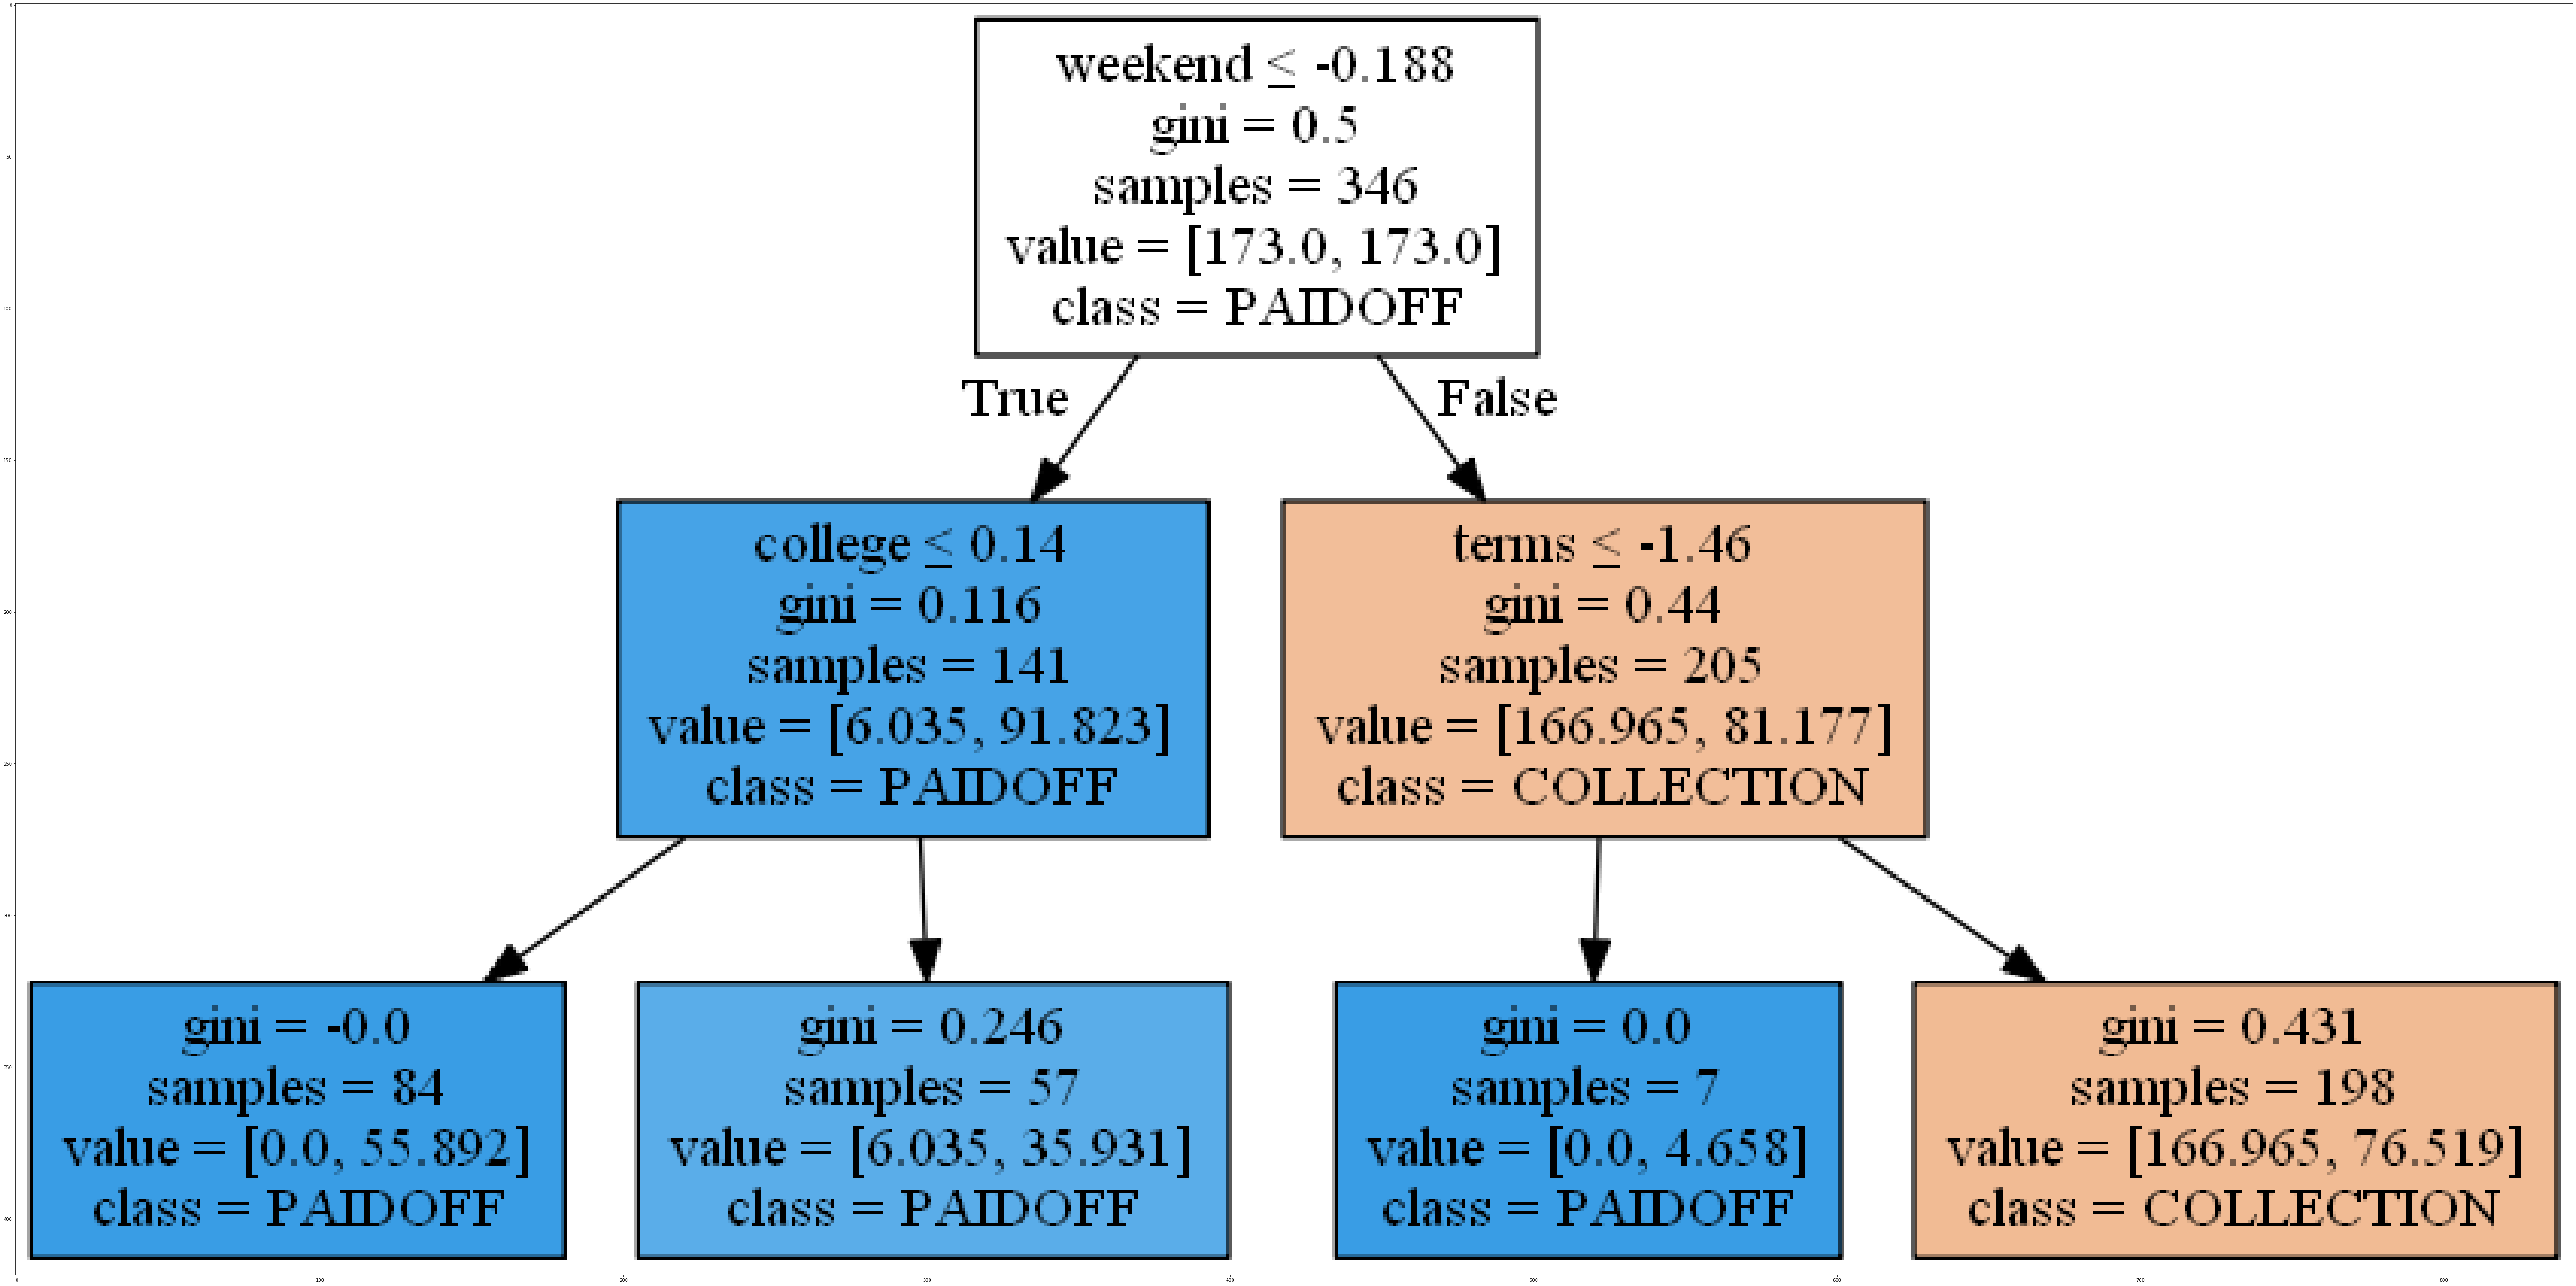

In [41]:
dot_data_DT = StringIO()
filename = "loanTree.png"
featureNames = Feature.columns
targetNames = np.unique(y)
out_DT=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data_DT, class_names=targetNames, filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data_DT.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100,200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [42]:
from sklearn import svm

I will try different kernelling functions, and try iterative loops with class_weight="balanced", and class_weight=None, as before, just in case (even though we can guess that "balanced" will work better)

In [43]:
# For SVM clasifier, I would want to try not only different kernel functions, but also different values of C, which determines how much outliers
# effect the margin. Since it's a lot of options to iterate around, I will using the GridSearchCV() to do it automatically

In [44]:
# y_bi = (y=='COLLECTION').astype(int)
# print(y_bi[0:10])

In [45]:
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# METRIC_TO_OPTIMIZE = "f1"
# scoring = ["accuracy", "f1", "roc_auc", "jaccard"]

# # accuracy_scorer = make_scorer(metrics.accuracy_score)
# # roc_auc_scorer = make_scorer(metrics.roc_auc_score)

# # scoring = {"accuracy": accuracy_scorer, "f1": f1_scorer, "roc_auc": roc_auc_scorer, "jaccard": jaccard_scorer}


# param_grid = {
#     "kernel":  ['rbf', 'sigmoid', 'poly'],
#     "gamma": ["auto", "scale"],
#     "C": np.linspace(1, 100, 100)
# }

# loanSVM_opt = GridSearchCV(
#     svm.SVC(class_weight='balanced'),
#     param_grid=param_grid,
#     scoring=scoring,
#     cv=StratifiedKFold(5, shuffle=True, random_state=21),
#     iid=True,
#     refit=METRIC_TO_OPTIMIZE
# )

# loanSVM_opt.fit(X, y_bi)

# print(loanSVM_opt.best_params_)
# print(loanSVM_opt.best_score_)

(I'm setting gamma='auto' to avoid deprecation warnings about "auto" when gamma is not explicitly specified)

In [46]:
kernel_functions = ['linear', 'poly', 'rbf', 'sigmoid']

def test_param_SVM(xaxis, class_weight):
    cv = StratifiedKFold(5, shuffle=True, random_state=21)
    mean_accuracy = []
    SE_accuracy = []
    mean_f1score = []
    SE_f1score = []
    mean_jaccard = []
    SE_jaccard = []
    params = []
    for function in kernel_functions:
        loan_clf = svm.SVC(kernel=function, gamma='auto', class_weight=class_weight)
        mean_accuracy.append(cross_val_score(loan_clf, X, y, cv=cv, scoring='accuracy').mean())
        SE_accuracy.append(cross_val_score(loan_clf, X, y, cv=cv, scoring='accuracy').std()/np.sqrt(5))
        mean_f1score.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=f1_scorer).mean())
        SE_f1score.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=f1_scorer).std()/np.sqrt(5))
        mean_jaccard.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=jaccard_scorer).mean())
        SE_jaccard.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=jaccard_scorer).std()/np.sqrt(5))
        params.append(function)
    mean_accuracy = np.asarray(mean_accuracy)
    mean_f1score = np.asarray(mean_f1score)
    mean_jaccard = np.asarray(mean_jaccard)
    print(mean_accuracy)
    print(mean_f1score)
    print(mean_jaccard)
    plt.figure()
    plt.bar(kernel_functions, mean_accuracy, yerr=SE_accuracy)
    plt.ylim(0.5, 0.76)
    plt.legend('Accuracy +/- StandErr')
    plt.ylabel('Accuracy')
    plt.xlabel(xaxis)
    plt.figure()
    plt.bar(kernel_functions, mean_f1score, yerr=SE_f1score)
#     plt.ylim(0.3, 0.7)
    plt.legend('F1 Score "COLLECTION" +/- StandErr')
    plt.ylabel('F1 Score "COLLECTION"')
    plt.xlabel(xaxis)
    plt.figure()
    plt.bar(kernel_functions, mean_jaccard, yerr=SE_jaccard)
    plt.ylim(0.5, 0.8)
    plt.legend('Jaccard +/- StandErr')
    plt.ylabel('Jaccard')
    plt.xlabel(xaxis)
    print("")
    print( "The best accuracy was", round(mean_accuracy.max(), 5), "with %s =" % xaxis,  params[mean_accuracy.argmax()]) 
    print( "The best F1 Score 'COLLECTION' was", round(mean_f1score.max(), 5), "with %s =" % xaxis,  params[mean_f1score.argmax()]) 
    print( "The best Jaccard Similarity score was", round(mean_jaccard.max(), 5), "with %s =" % xaxis,  params[mean_jaccard.argmax()])
    best_fit = {
        '1: Classifier': 'loanSVM, %s %s, %s' % (xaxis, params[mean_f1score.argmax()], class_weight),
        '2: Accuracy': mean_accuracy.max(),
        '3: F1 Score "COLLECTION"': mean_f1score.max(),
        '4: Jaccard': mean_jaccard.max(),
    }
    clfs_list.append(best_fit)

C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

[0.74861284 0.73693582 0.72848861 0.73122153]
[0.         0.07217391 0.02962963 0.09019386]
[0.74861284 0.73693582 0.72848861 0.73122153]

The best accuracy was 0.74861 with Kernel Function = linear
The best F1 Score 'COLLECTION' was 0.09019 with Kernel Function = sigmoid
The best Jaccard Similarity score was 0.74861 with Kernel Function = linear


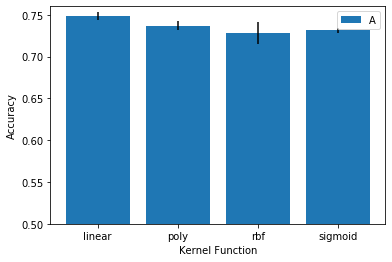

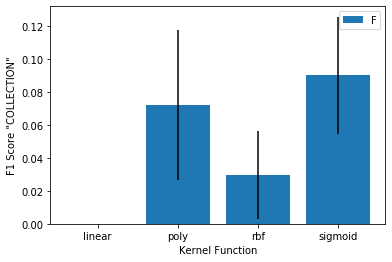

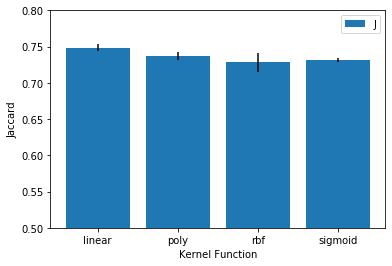

In [47]:
test_param_SVM('Kernel Function', None)

[0.62716356 0.65035197 0.65606625 0.60989648]
[0.54056139 0.56352612 0.57056807 0.51345897]
[0.62716356 0.65035197 0.65606625 0.60989648]

The best accuracy was 0.65607 with Kernel Function = rbf
The best F1 Score 'COLLECTION' was 0.57057 with Kernel Function = rbf
The best Jaccard Similarity score was 0.65607 with Kernel Function = rbf


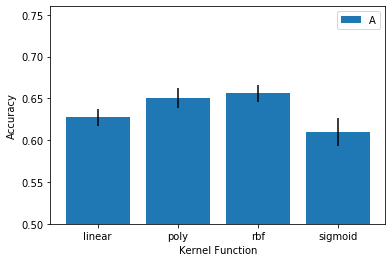

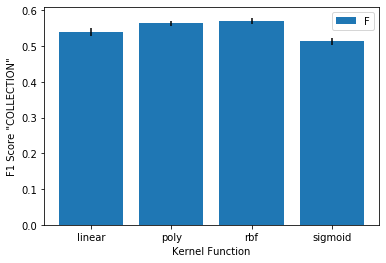

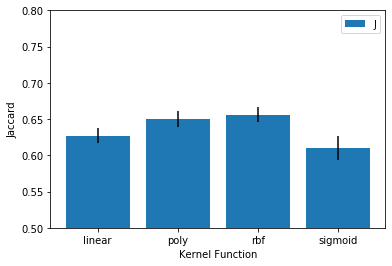

In [48]:
test_param_SVM('Kernel Function', 'balanced')

In [49]:
pd.DataFrame(clfs_list)

,1: Classifier,2: Accuracy,"3: F1 Score ""COLLECTION""",4: Jaccard
0,"loanKNN, Number of Neighbors (K) 6",0.760207,0.486849,0.760207
1,"loanTree, Max Depth of Tree 15, entropy, None",0.751470,0.406375,0.751470
2,"loanTree, Max Depth of Tree 2, entropy, balanced",0.670683,0.584776,0.667785
3,"loanTree, Max Depth of Tree 10, gini, None",0.751470,0.398977,0.751470
4,"loanTree, Max Depth of Tree 2, gini, balanced",0.676439,0.584776,0.673540
5,"loanSVM, Kernel Function sigmoid, None",0.748613,0.090194,0.748613
6,"loanSVM, Kernel Function rbf, balanced",0.656066,0.570568,0.656066


Same as before, even though accuracy and jaccard scores are better when class_weight=None, I will use the F1 score, since it's a better indicator of how well we can predict "COLLECTION" class, to know if someone defaults on their loan. 

Therefore, I got the best scores using class_weight="balanced", kernel="rbf", and I can build my SVM Classifier. 

NOTE: I'm using the entire feature set X and target y to train because I used cross-validation method to optimize parameters 
(Note that I'm fitting to the entire X and y set because I used cross-validation technique to find the best parameters)

In [50]:
loanSVM = svm.SVC(kernel='rbf', gamma='auto', class_weight='balanced').fit(X,y)
loanSVM

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression

I will try different solvers, and class_weight="balanced"/None, as before, just in case (even though we can guess that "balanced" will work better)

In [83]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

def test_param_LR(xaxis, class_weight):
    cv = StratifiedKFold(5, shuffle=True, random_state=21)
    mean_accuracy = []
    SE_accuracy = []
    mean_f1score = []
    SE_f1score = []
    mean_jaccard = []
    SE_jaccard = []
    params = []
    for solver in solvers:
        loan_clf = LogisticRegression(C=0.01, solver=solver, class_weight=class_weight)
        mean_accuracy.append(cross_val_score(loan_clf, X, y, cv=cv, scoring='accuracy').mean())
        SE_accuracy.append(cross_val_score(loan_clf, X, y, cv=cv, scoring='accuracy').std()/np.sqrt(5))
        mean_f1score.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=f1_scorer).mean())
        SE_f1score.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=f1_scorer).std()/np.sqrt(5))
        mean_jaccard.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=jaccard_scorer).mean())
        SE_jaccard.append(cross_val_score(loan_clf, X, y, cv=cv, scoring=jaccard_scorer).std()/np.sqrt(5))
        params.append(solver)
    mean_accuracy = np.asarray(mean_accuracy)
    mean_f1score = np.asarray(mean_f1score)
    mean_jaccard = np.asarray(mean_jaccard)
    
    print(mean_accuracy)
    print(mean_f1score)
    print(mean_jaccard)
    
    plt.figure()
    plt.bar(solvers, mean_accuracy, yerr=SE_accuracy)
    plt.ylim(0.5, 0.76)
    plt.legend('Accuracy +/- StandErr')
    plt.ylabel('Accuracy')
    plt.xlabel(xaxis)
    plt.figure()
    plt.bar(solvers, mean_f1score, yerr=SE_f1score)
#     plt.ylim(0.3, 0.7)
    plt.legend('F1 Score "COLLECTION" +/- StandErr')
    plt.ylabel('F1 Score "COLLECTION"')
    plt.xlabel(xaxis)
    plt.figure()
    plt.bar(solvers, mean_jaccard, yerr=SE_jaccard)
    plt.ylim(0.5, 0.8)
    plt.legend('Jaccard +/- StandErr')
    plt.ylabel('Jaccard')
    plt.xlabel(xaxis)
    
    print("")
    print( "The best accuracy was", round(mean_accuracy.max(), 5), "with %s =" % xaxis,  params[mean_accuracy.argmax()]) 
    print( "The best F1 Score 'COLLECTION' was", round(mean_f1score.max(), 5), "with %s =" % xaxis,  params[mean_f1score.argmax()]) 
    print( "The best Jaccard Similarity score was", round(mean_jaccard.max(), 5), "with %s =" % xaxis,  params[mean_jaccard.argmax()])
    
    best_fit = {
        '1: Classifier': 'loanLR, %s %s, %s' % (xaxis, params[mean_f1score.argmax()], class_weight),
        '2: Accuracy': mean_accuracy.max(),
        '3: F1 Score "COLLECTION"': mean_f1score.max(),
        '4: Jaccard': mean_jaccard.max(),
    }
    clfs_list.append(best_fit)

C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

[0.75 0.75 0.73 0.75 0.75]
[0.   0.   0.08 0.   0.  ]
[0.75 0.75 0.73 0.75 0.75]

The best accuracy was 0.75147 with Solver = newton-cg
The best F1 Score 'COLLECTION' was 0.0818 with Solver = liblinear
The best Jaccard Similarity score was 0.75147 with Solver = newton-cg


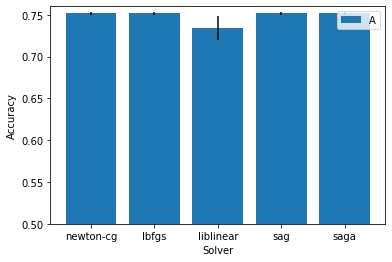

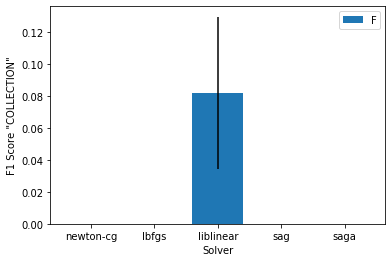

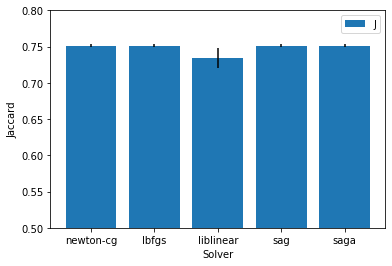

In [84]:
test_param_LR('Solver', None)

[0.6647205  0.6647205  0.64732919 0.6647205  0.6647205 ]
[0.57331423 0.57331423 0.56729103 0.57331423 0.57331423]
[0.6647205  0.6647205  0.64732919 0.6647205  0.6647205 ]

The best accuracy was 0.66472 with Solver = newton-cg
The best F1 Score 'COLLECTION' was 0.57331 with Solver = newton-cg
The best Jaccard Similarity score was 0.66472 with Solver = newton-cg


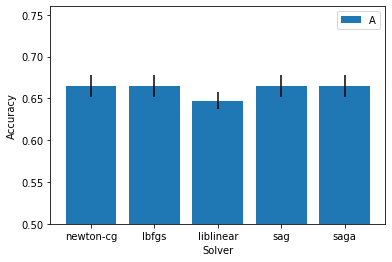

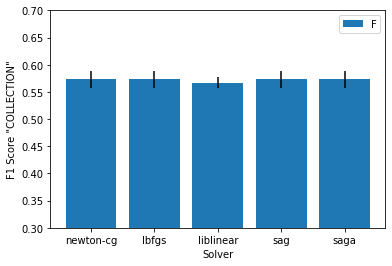

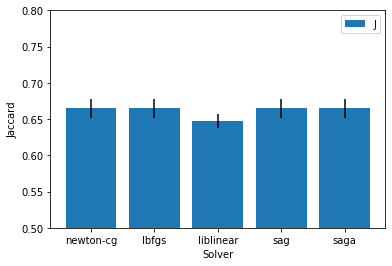

In [54]:
test_param_LR('Solver', 'balanced')

In [55]:
pd.DataFrame(clfs_list)

,1: Classifier,2: Accuracy,"3: F1 Score ""COLLECTION""",4: Jaccard
0,"loanKNN, Number of Neighbors (K) 6",0.760207,0.486849,0.760207
1,"loanTree, Max Depth of Tree 15, entropy, None",0.751470,0.406375,0.751470
2,"loanTree, Max Depth of Tree 2, entropy, balanced",0.670683,0.584776,0.667785
3,"loanTree, Max Depth of Tree 10, gini, None",0.751470,0.398977,0.751470
4,"loanTree, Max Depth of Tree 2, gini, balanced",0.676439,0.584776,0.673540
5,"loanSVM, Kernel Function sigmoid, None",0.748613,0.090194,0.748613
6,"loanSVM, Kernel Function rbf, balanced",0.656066,0.570568,0.656066
7,"loanLR, Solver liblinear, None",0.751470,0.081804,0.751470
8,"loanLR, Solver newton-cg, balanced",0.664720,0.573314,0.664720


Same as before, even though accuracy and jaccard scores are better when class_weight=None, I will use the F1 score, since it's a better indicator of how well we can predict "COLLECTION" class, to know if someone defaults on their loan. 

Therefore, I got the best scores using class_weight="balanced", solver='newton-cg', and I can build my Logistic Regression Classifier. 

NOTE: I'm using the entire feature set `X` and target `y` to train because I used cross-validation method to optimize parameters.

In [56]:
loanLR = LogisticRegression(C=0.01, solver='newton-cg', class_weight='balanced').fit(X,y)
loanLR

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

# Model Evaluation using Test set

In [57]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [58]:
# !wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation 

In [59]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [60]:
test_df.shape

(54, 10)

### Pre-processing of Test set

### 1. Making a binary weekend feature

In [61]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [62]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


### 2. Covert categorical features to numerical values

In [63]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [64]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [65]:
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [66]:
Test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
Test_Feature = pd.concat([Test_Feature,pd.get_dummies(test_df['education'])], axis=1)
Test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
Test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [67]:
Test_Feature.shape

(54, 8)

### Feature and y selection for Test set

In [68]:
X_test = Test_Feature
X_test[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [69]:
y_test = test_df['loan_status'].values
y_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Normalize the test feature set

#### I'm using the original Feature set to fit the test data for normalization in order to keep the same mean and std as the train set

In [70]:
X_test = preprocessing.StandardScaler().fit(Feature).transform(X_test)
X_test[0:5]

array([[ 0.51578458,  0.92071769,  3.16061891,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [-5.89052444, -1.96168647,  0.67333883, -0.42056004,  0.82934003,
        -0.38170062, -0.87997669, -0.86968108],
       [ 0.51578458,  0.92071769,  1.9998882 ,  2.37778177,  0.82934003,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769, -0.81902922, -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [-1.31458942, -0.95911111, -0.3215732 , -0.42056004,  0.82934003,
         2.61985426, -0.87997669, -0.86968108]])

# Predicting with my classifiers 

In [71]:
yhat_KNN = loanKNN.predict(X_test)
yhat_Tree = loanTree.predict(X_test)
yhat_SVM = loanSVM.predict(X_test)
yhat_LR = loanLR.predict(X_test)

Creating a table with metrics for each classifier: 

In [72]:
test_scores = []
for classifier_name, yhat in [
    ('K-Nearest Neighbours (6)', yhat_KNN),
    ('Decision Tree (Max Depths 2)', yhat_Tree),
    ('SVM (rbf)', yhat_SVM),
    ('Logistic Regression', yhat_LR)
]:
    scores = {
        'Classifier': classifier_name,
        'Jaccard': round(jaccard_similarity_score(y_test, yhat), 5),
        'F1 Score ("COLLECTION")': round(f1_score(y_test, yhat, pos_label='COLLECTION'), 5),
        'F1 Score (weighted)': round(f1_score(y_test, yhat, average='weighted'), 5)
    }
    test_scores.append(scores)
pd.DataFrame(test_scores)

,Classifier,"F1 Score (""COLLECTION"")",F1 Score (weighted),Jaccard
0,K-Nearest Neighbours (6),0.38462,0.69592,0.70370
1,Decision Tree (Max Depths 2),0.60465,0.70377,0.68519
2,SVM (rbf),0.59091,0.68561,0.66667
3,Logistic Regression,0.52381,0.65208,0.62963


Log-loss for Logistic Regression:

In [73]:
yhat_LRprob = loanLR.predict_proba(X_test)
print ("LogLoss: %.2f" % log_loss(y_test, yhat_LRprob))

LogLoss: 0.60


### My best classifier therefore, appears to be the Decision Tree, with max depth of 2, balanced class weight, and "gini" criterion

### Now I will plot confusion matrices for my classifiers, just to see if everything makes sense 

In [74]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Compute confusion matrix for Decision Tree:

Confusion matrix, without normalization
[[24 16]
 [ 1 13]]


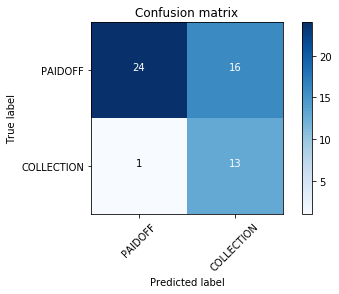

In [75]:
cnf_matrix = confusion_matrix(y_test, yhat_Tree, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

=> Result for Decision Tree: Even though the fraction of False Positives is rather high, the fraction of False Negatives is very low, and that might be what's most important for the bank 


Compute confusion matrix for K-Nearest Neighbors:

Confusion matrix, without normalization
[[33  7]
 [ 9  5]]


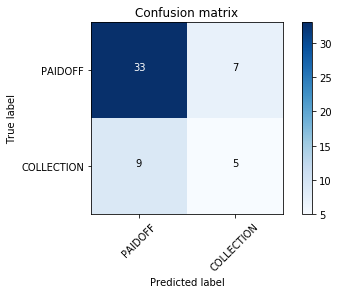

In [76]:
cnf_matrix = confusion_matrix(y_test, yhat_KNN, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

=> Result for K-Nearest Neighbors: very high fraction of False Negatives, don't be able to predict going into "COLLECTION" well

Compute confusion matrix for SVM:

Confusion matrix, without normalization
[[23 17]
 [ 1 13]]


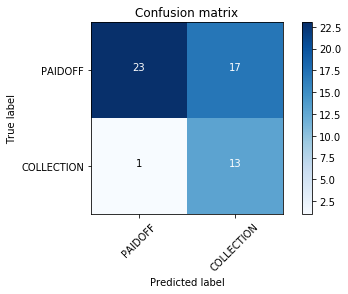

In [77]:
cnf_matrix = confusion_matrix(y_test, yhat_SVM, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

=> Result for SVM: good low fraction of False Negatives, but slightly bigger fraction of False Positives than Decision Tree, i.e., second-best performer

 Compute confusion matrix for Logistic Regression:

Confusion matrix, without normalization
[[23 17]
 [ 3 11]]


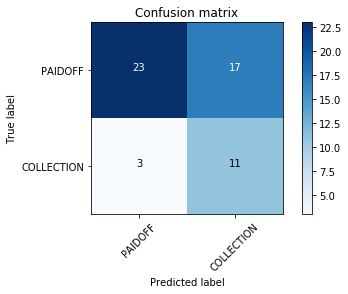

In [78]:
cnf_matrix = confusion_matrix(y_test, yhat_LR, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

=> Result for Logistic Regression: both fraction of False Postives and False Negatives is slightly highest than Decision Tree, i.e., third best performer

In [79]:
pd.DataFrame(test_scores)

,Classifier,"F1 Score (""COLLECTION"")",F1 Score (weighted),Jaccard
0,K-Nearest Neighbours (6),0.38462,0.69592,0.70370
1,Decision Tree (Max Depths 2),0.60465,0.70377,0.68519
2,SVM (rbf),0.59091,0.68561,0.66667
3,Logistic Regression,0.52381,0.65208,0.62963


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.7037  | 0.69592  | NA      |
| Decision Tree      | 0.68519 | 0.70377  | NA      |
| SVM                | 0.66667 | 0.68561  | NA      |
| LogisticRegression | 0.62963 | 0.65208  | 0.60    |

NOTE: I'm reporting weighted average F1 Score, but F1 Score for "COLLECTION" class alone is also shown above

### My best classifier therefore is the Decision Tree, with max depth of 2, balanced class weight, and entropy criterion

# Thanks for taking the time to evaluate!!

In [80]:
SVM_model = svm.SVC()
SVM_model.fit(X, y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [81]:
y_hattest = SVM_model.predict(X_test)
y_hattest

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF'], dtype=object)

Confusion matrix, without normalization
[[39  1]
 [14  0]]


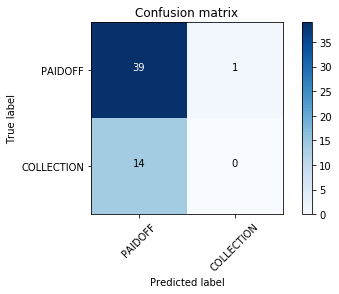

In [82]:
cnf_matrix = confusion_matrix(y_test, y_hattest, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')